<h1>Project 3: Swan Teleco</h1>
<h3>Customer Retention Marketing</h2>

Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from time import time

%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


Functions for Model Evaluation

In [2]:
def apr(y_pred, y_real):


    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1


##

def produce_confusion(positive_label, negative_label,y_test,y_pred):
    
   
    #Build the CM
    plt.figure(figsize=(7,5))

    cm = metrics.confusion_matrix(y_test, y_pred) 
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
    ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])

    plt.show()


### Import Data

In [3]:
file_name = "customer_churn.xlsx"
df = pd.read_excel(file_name,sheet_name='Telco_Churn')
df.shape

(7043, 31)

In [4]:
cols_to_remove =  ['Count','Churn Label','Lat Long','Country','State','City']

df.drop(columns = cols_to_remove, inplace = True)

# remove rows with whitespaces as values
df = df.drop(df[df['Total Charges'] == ' '].index)
df = df.drop(df[df['Monthly Charges'] == ' '].index)
df.shape

(7032, 25)

In [5]:
df.isnull().mean().round(4) * 100

CustomerID            0.00
Zip Code              0.00
Latitude              0.00
Longitude             0.00
Gender                0.00
Senior Citizen        0.00
Partner               0.00
Dependents            0.00
Tenure Months         0.00
Phone Service         0.00
Multiple Lines        0.00
Internet Service      0.00
Online Security       0.00
Online Backup         0.00
Device Protection     0.00
Tech Support          0.00
Streaming TV          0.00
Streaming Movies      0.00
Contract              0.00
Paperless Billing     0.00
Payment Method        0.00
Monthly Charges       0.00
Total Charges         0.00
Churn Value           0.00
Churn Reason         73.42
dtype: float64

In [6]:
df[df['Churn Value'] == 0].shape

(5163, 25)

In [7]:
df[df['Churn Reason'].isnull()].shape

(5163, 25)

# Data Preparation

<li>In this part we split unchurned rows into train and test. This test data will be <i>X_test</i></li>
<li>Then we combine the churned data rows with unchurned train rows to form <i>X_train</i></li>

In [8]:
# split as churned and unchurned datadrames 

churned_df = df.loc[df['Churn Value'] == 1]
unchurned_df = df.loc[df['Churn Value'] == 0]

print(churned_df.shape)
print(unchurned_df.shape)

(1869, 25)
(5163, 25)


In [9]:
feature_cols = list(df.columns)
feature_cols.remove('Churn Value')


# split into features and dependent variable
X_churned = churned_df[feature_cols]
y_churned = churned_df['Churn Value']


X_unchurned = unchurned_df[feature_cols]
y_unchurned = unchurned_df['Churn Value']

In [10]:
X_train_uc, X_test_uc, y_train_uc, y_test_uc = train_test_split(X_unchurned, y_unchurned, test_size = 0.6, random_state = 20)
print('X_train shape:',X_train_uc.shape)
print('y_train shape:',y_train_uc.shape)
print('X_test shape:',X_test_uc.shape)
print('y_test shape:',y_test_uc.shape)

X_train shape: (2065, 24)
y_train shape: (2065,)
X_test shape: (3098, 24)
y_test shape: (3098,)


### Train Test Split

In [11]:
# Combine X_churned and X_train_uc to produce X_train
X_train = pd.concat([X_churned,X_train_uc])

# Combine y_churned and y_train_uc to produce y_train
y_train = pd.concat([y_churned,y_train_uc])


X_test = X_unchurned
y_test = y_unchurned

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (3934, 24)
y_train shape: (3934,)
X_test shape: (5163, 24)
y_test shape: (5163,)


###  Feature Engineering

In [12]:
def feature_eng(df):
    
        df['Monthly Charges'].astype('float').astype('int')
   
    
        # # scaling
        st_scaler = StandardScaler()

        col_transformer = ColumnTransformer(verbose = True, transformers = [('ss', st_scaler, ['Monthly Charges', 'Tenure Months'])])
        depth_transform = col_transformer.fit_transform(df)
        df_scaled = pd.DataFrame(depth_transform,index=df.index, columns =['Monthly Charges', 'Tenure Months'])

        df[['mileage', 'BHP']]  = df_scaled.copy()

        cols_to_ohe = {'Device Protection',
                'Tech Support',
                'Phone Service',
                'Contract',
                'Streaming Movies',
                'Online Security',
                'Dependents',
                'Payment Method',
                'Online Backup',
                'Paperless Billing',
                'Senior Citizen',
                'Multiple Lines',
                'Gender',
                'Partner',
                'Internet Service',
                'Streaming TV'
                }

        # ohe
        for col in cols_to_ohe:

                df = pd.get_dummies(df, columns = [col], drop_first = True, prefix = col)


        return df



In [13]:
X_train = feature_eng(X_train)
X_test = feature_eng(X_test)
X_unchurned = feature_eng(X_unchurned)

len(list(X_train.columns))

[ColumnTransformer] ............ (1 of 1) Processing ss, total=   0.0s
[ColumnTransformer] ............ (1 of 1) Processing ss, total=   0.0s
[ColumnTransformer] ............ (1 of 1) Processing ss, total=   0.0s


37

# Modelling

In [14]:
def get_best_params(X,y):
    """
    Gets the best params
    i/p:X,y
    o/p:params
    """
    rf = RandomForestClassifier(n_estimators=50)
   
   
    rf_params = {
    'n_estimators': [150,200,250],
    'max_depth': [ x for x in range(1,len(X.columns))],
    }

    gs = GridSearchCV(rf, param_grid=rf_params, cv=5,error_score="raise")

    gs.fit(X, y)

    print(gs.best_score_)

    params = gs.best_params_
        
    return params

In [15]:
X_train.head(2)

,CustomerID,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Reason,mileage,BHP,...,Multiple Lines_No phone service,Multiple Lines_Yes,Contract_One year,Contract_Two year,Dependents_Yes,Online Backup_No internet service,Online Backup_Yes,Tech Support_No internet service,Tech Support_Yes,Senior Citizen_Yes
0,3668-QPYBK,90003,33.964131,-118.272783,2,53.85,108.15,Competitor made better offer,-0.466082,-1.080369,...,0,0,0,0,0,0,1,0,0,0
1,9237-HQITU,90005,34.059281,-118.307420,2,70.70,151.65,Moved,0.115136,-1.080369,...,0,0,0,0,1,0,0,0,0,0


In [16]:
all_cols = set(X_train.columns)

cols_to_remove = {'Country',
                    'City',
                    'State',
                    'CustomerID',
                    'Zip Code',
                    'Lat Long',
                    'Total Charges',
                    'Internet Service_Fiber optic',
                    'Internet Service_No',
                    'Multiple Lines_No phone service',
                    'Latitude',
                    'Longitude',
                    'Churn Reason'
                    }
cols_filtered = list(all_cols-cols_to_remove)


In [17]:
X_train[cols_filtered].dtypes

Partner_Yes                                 uint8
mileage                                   float64
Online Backup_Yes                           uint8
Dependents_Yes                              uint8
Multiple Lines_Yes                          uint8
Streaming TV_Yes                            uint8
Device Protection_No internet service       uint8
Payment Method_Credit card (automatic)      uint8
Online Backup_No internet service           uint8
Streaming Movies_No internet service        uint8
BHP                                       float64
Tenure Months                               int64
Online Security_No internet service         uint8
Payment Method_Electronic check             uint8
Device Protection_Yes                       uint8
Senior Citizen_Yes                          uint8
Gender_Male                                 uint8
Payment Method_Mailed check                 uint8
Online Security_Yes                         uint8
Monthly Charges                           float64


In [18]:
best_params = get_best_params(X_train[cols_filtered],y_train)

rf_base = RandomForestClassifier(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'])
rf_base.fit(X_train[cols_filtered],y_train)


0.7679192087710278


RandomForestClassifier(max_depth=7, n_estimators=250)

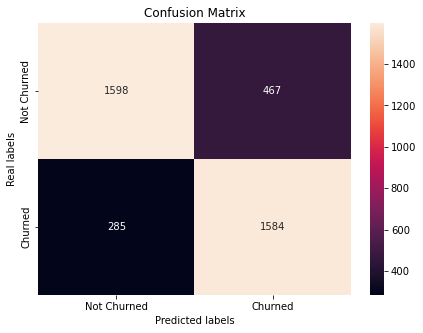

In [19]:
## Prediction
y_pred = rf_base.predict(X_train[cols_filtered])

produce_confusion('Churned', 'Un-Churned',y_train,y_pred)


In [20]:
best_params

{'max_depth': 7, 'n_estimators': 250}

In [21]:
imp_features = rf_base.feature_names_in_

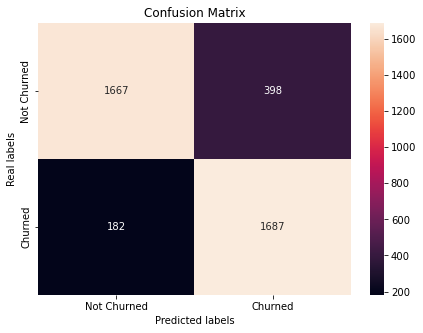

Score: 0.8525673614641586
Accuracy:0.8525673614641586
Precision:0.8091127098321343
Recall:0.9026217228464419
F1:0.8533131006575619


In [22]:
best_rf = RandomForestClassifier(n_estimators=250,max_depth=9)
best_rf.fit(X_train[imp_features],y_train)
## Prediction
y_pred = best_rf.predict(X_train[imp_features])

## Predicted Probabilities!
y_pred_prob = best_rf.predict_proba(X_train[imp_features])

produce_confusion('Churned', 'Un-Churned',y_train,y_pred)


print('Score:',best_rf.score(X_train[imp_features],y_train))
train_scores = apr(y_pred, y_train)


Test data

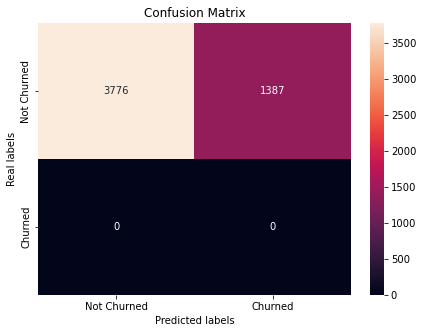

Score: 0.7313577377493705
Accuracy:0.7313577377493705
Precision:0.0
Recall:0.0
F1:0.0


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:


y_pred = best_rf.predict(X_test[imp_features])
y_pred_prob = best_rf.predict_proba(X_test[imp_features])



produce_confusion('Churned', 'Un-Churned',y_test,y_pred)

print('Score:',best_rf.score(X_test[imp_features],y_test))
test_scores = apr(y_pred, y_test)


# Find 500 customers most likely to churn

In [24]:
X_unchurned['churn_probability'] = best_rf.predict_proba(X_unchurned[imp_features]).T[0]
customers = X_unchurned.sort_values(by='churn_probability', axis=0, ascending=False)
customers_500 = customers['CustomerID'].head(500)



In [25]:
customers_500.to_csv('customers_500.csv',index=False)

### Churn Risk of Remaining Customers

In [26]:
# find remaining customer id who are still un-churned
rem_customers = set(unchurned_df['CustomerID'])-set(customers_500)
# get a dataframe of remaining customers
rem_unchurned = X_unchurned[X_unchurned['CustomerID'].isin(rem_customers)]
rem_unchurned.shape

(4663, 38)

In [27]:
# finds the churn probability of remaining customers
y_rem_pred_prob = best_rf.predict_proba(rem_unchurned[imp_features]).T[0]
remain_cust = rem_unchurned[['CustomerID']].copy()
remain_cust['churn_probability'] = y_rem_pred_prob
remain_cust = remain_cust.sort_values('churn_probability',ascending=False)


In [28]:
remain_cust.to_csv('churn_probabilities.csv',index=False)